In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

2023-04-28 17:14:49.502071: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
img_path = './data/cats_and_dogs_small/test/cats/cat.1700.jpg'

from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

img = load_img(img_path, target_size=(150, 150, 3))
img_tensor = img_to_array(img)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)
img_tensor /= 255.

print(img_tensor.shape)

(150, 150, 3)
(1, 150, 150, 3)
(1, 150, 150, 3)


打印图片

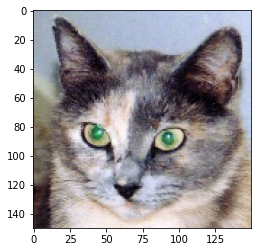

In [13]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [15]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


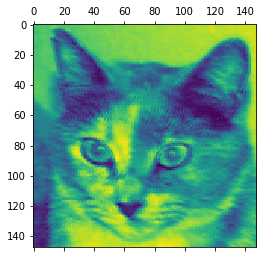

In [16]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

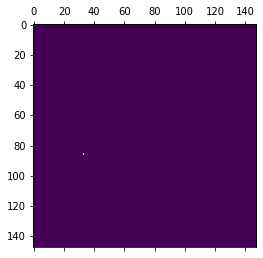

In [17]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')


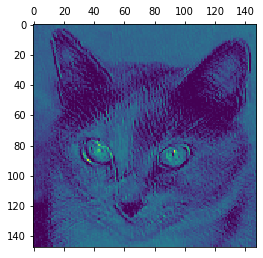

In [18]:
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')


/var/folders/2y/6zpyxsv91h5f6rkk2bhks16c0000gp/T/ipykernel_28509/1928128219.py:18: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
/var/folders/2y/6zpyxsv91h5f6rkk2bhks16c0000gp/T/ipykernel_28509/1928128219.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(scale * display_grid.shape[1],


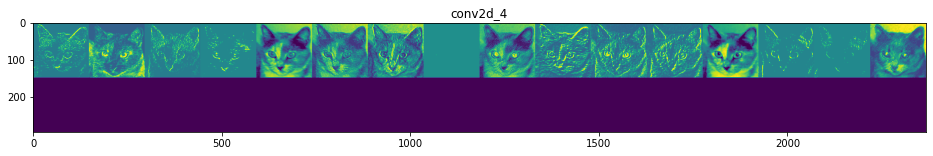

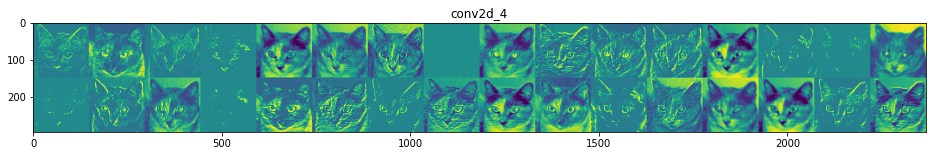

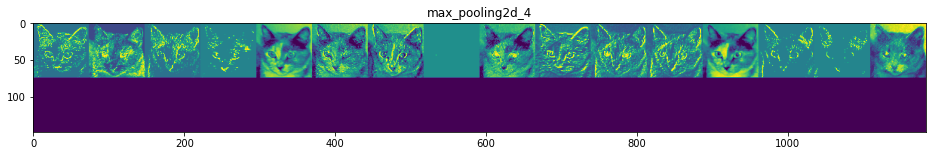

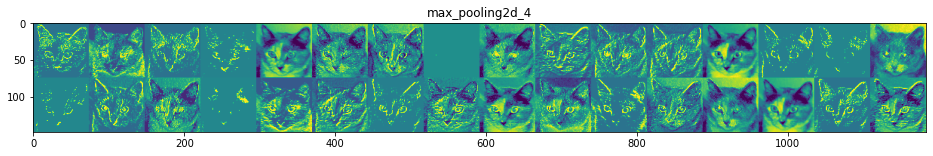

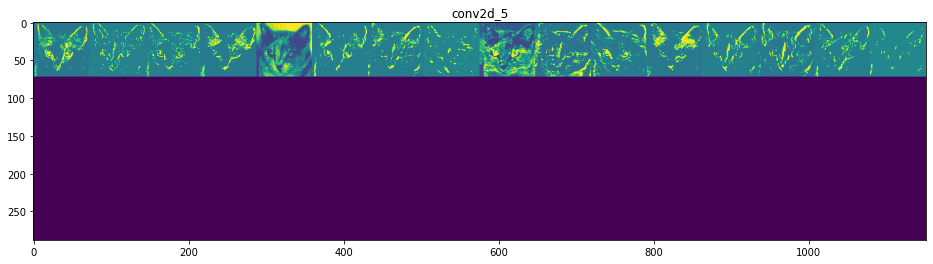

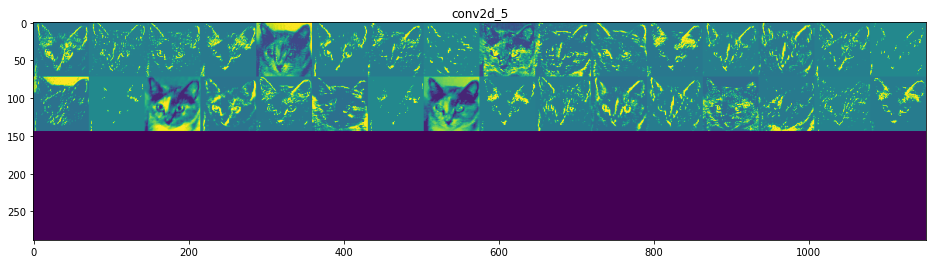

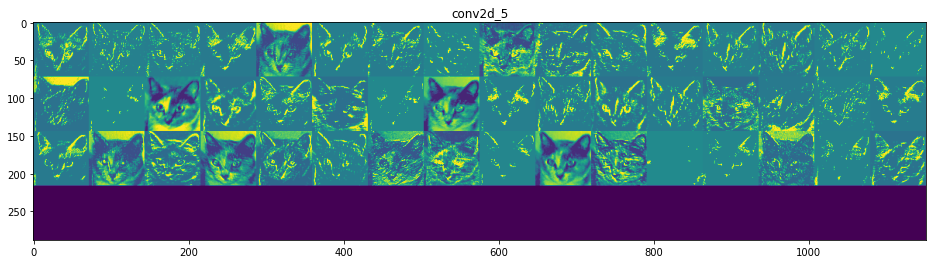

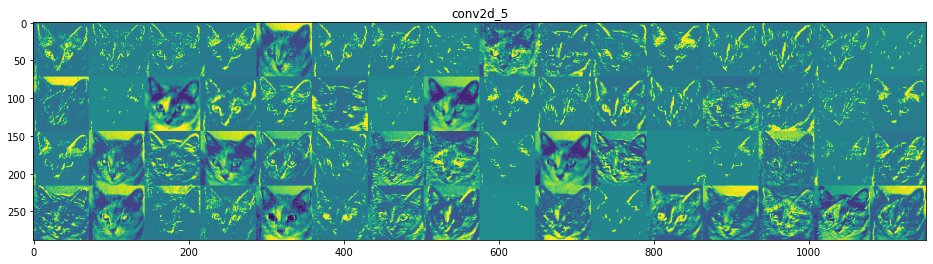

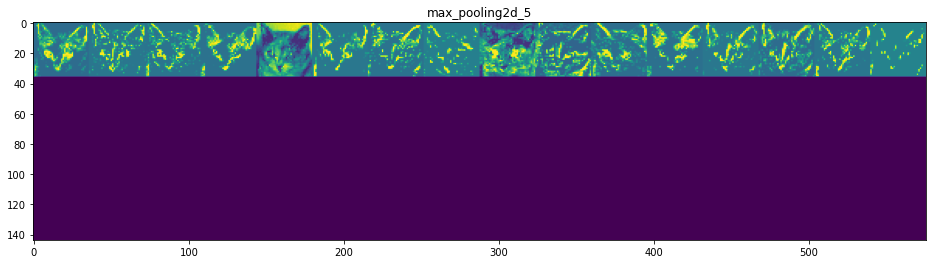

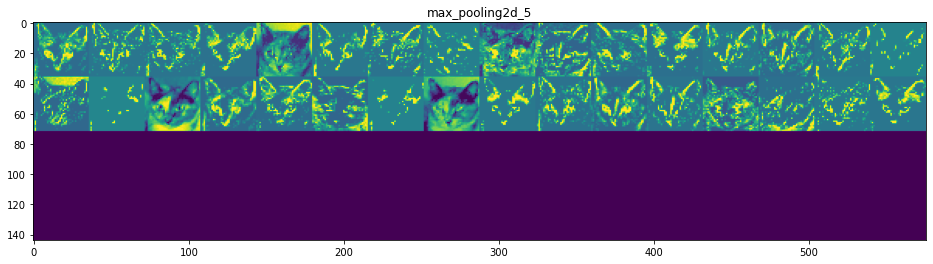

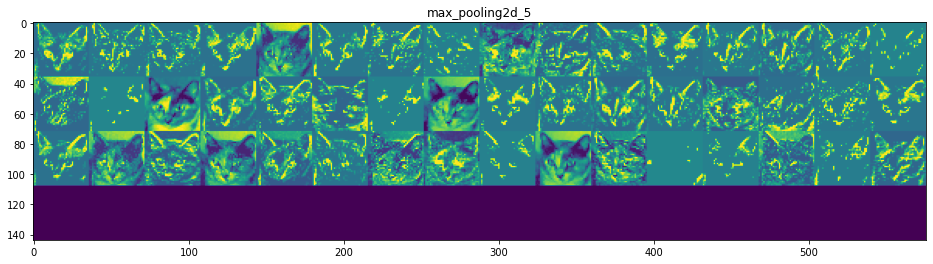

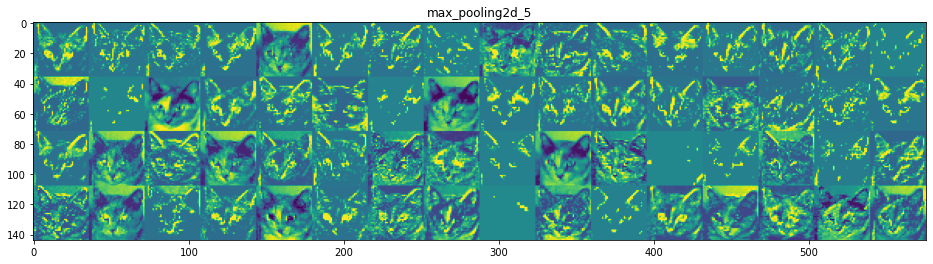

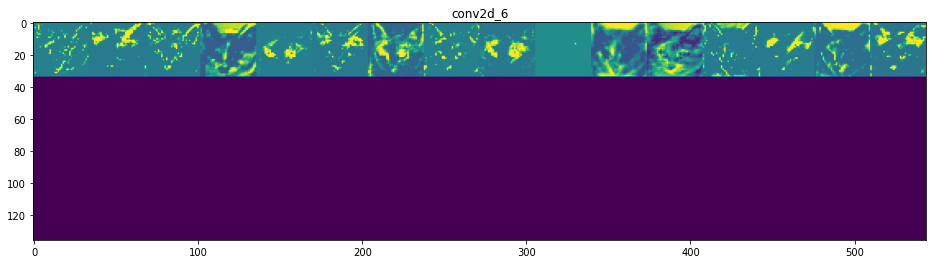

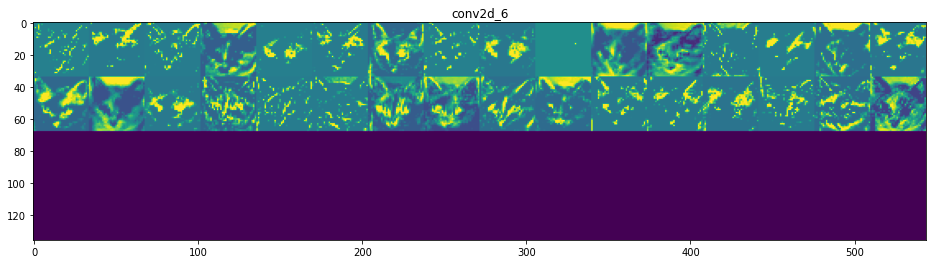

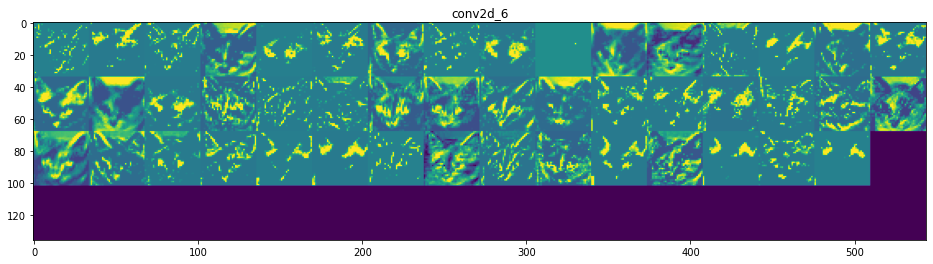

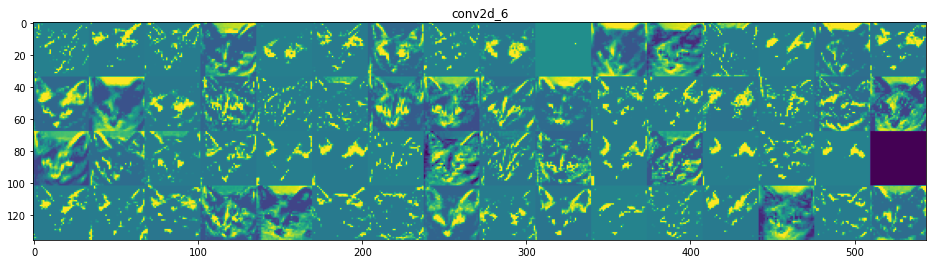

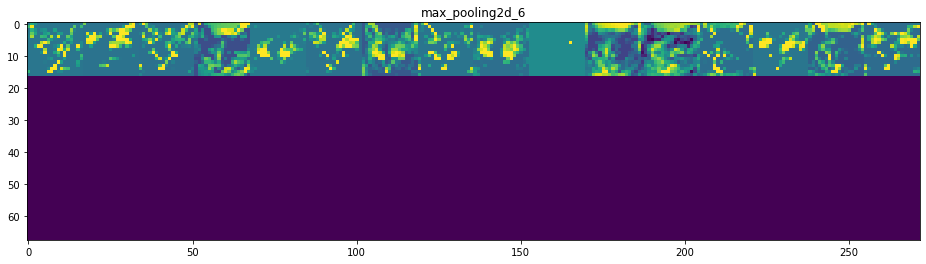

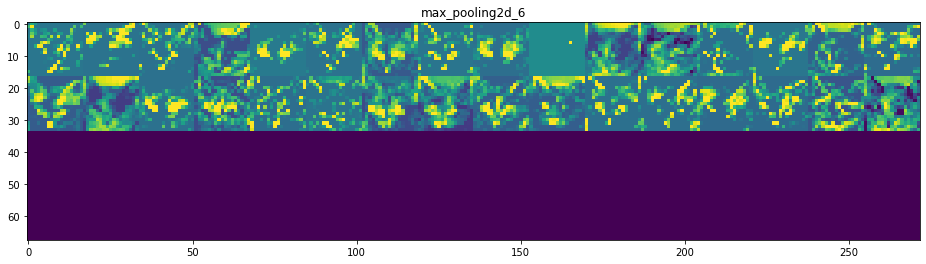

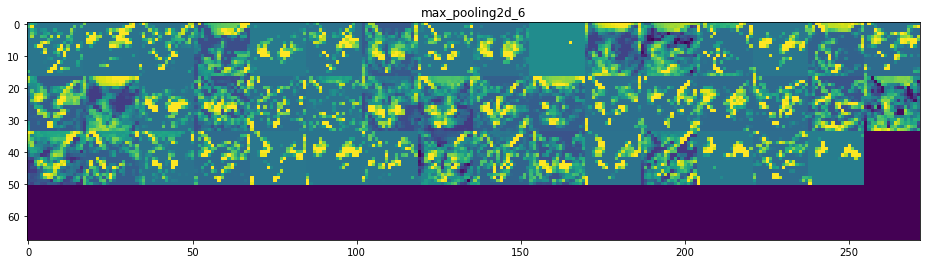

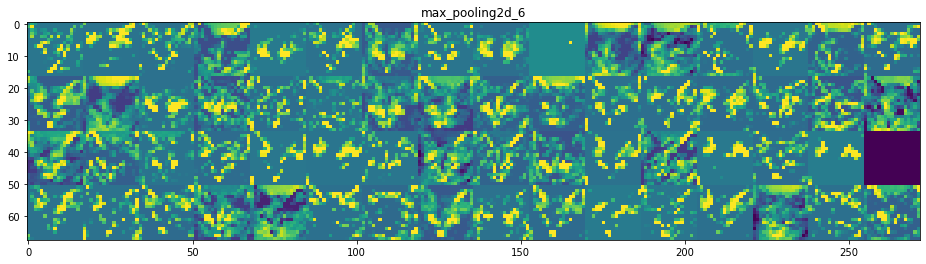

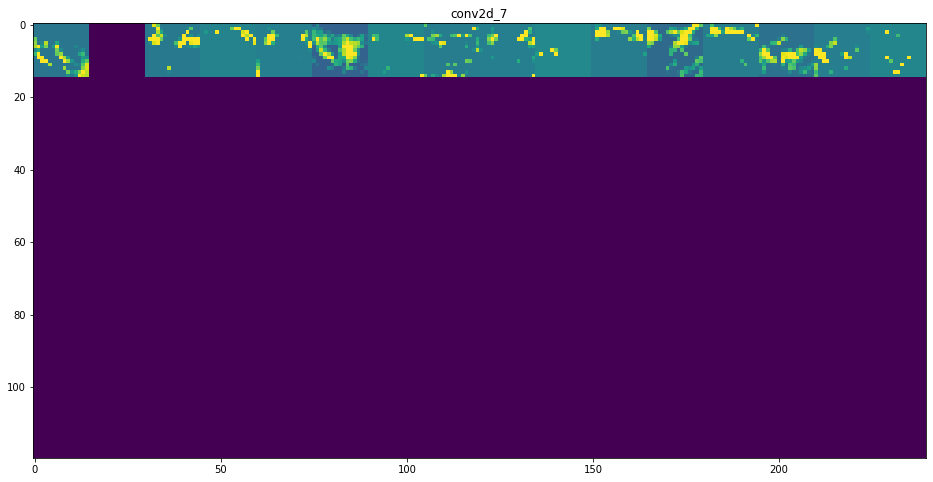

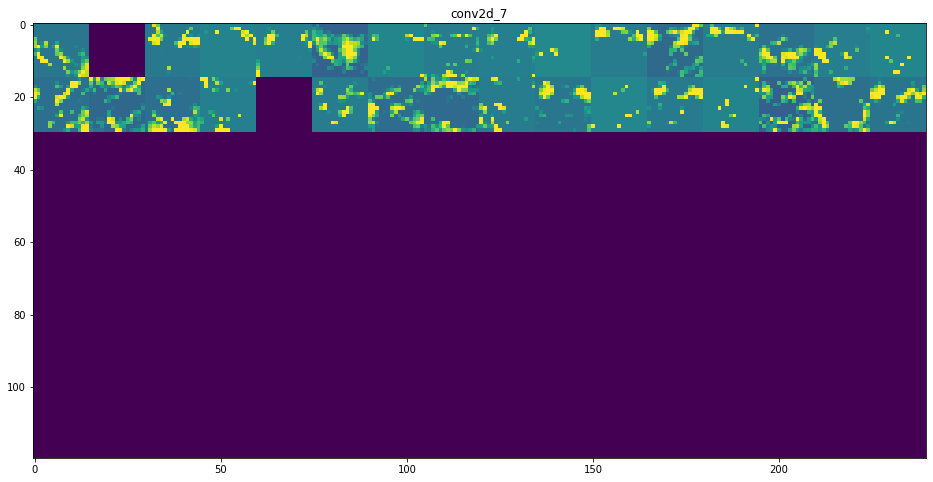

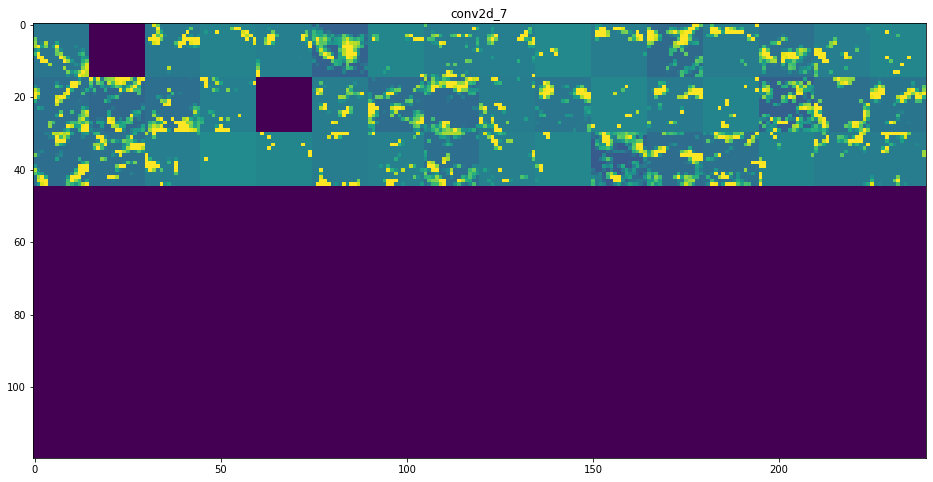

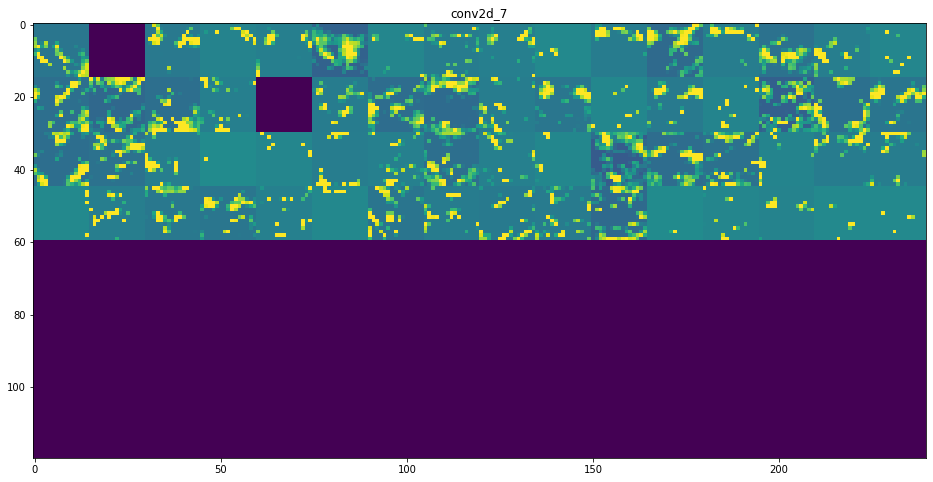

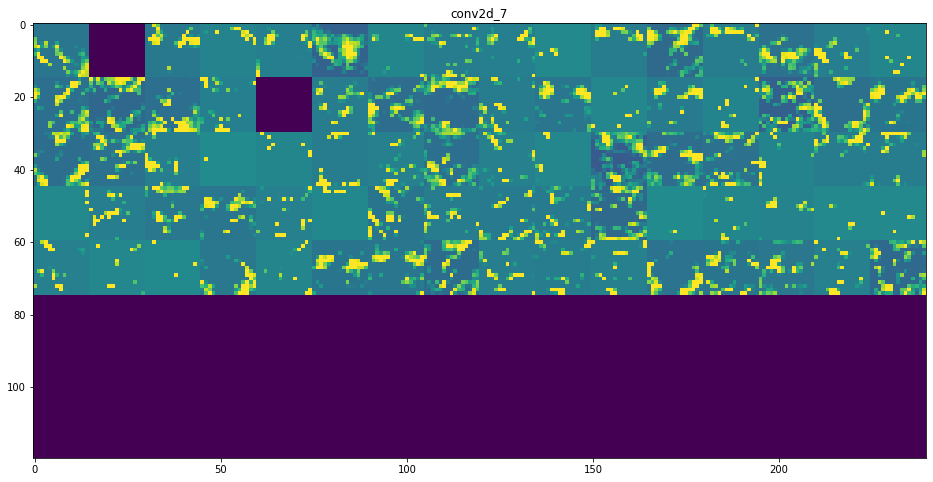

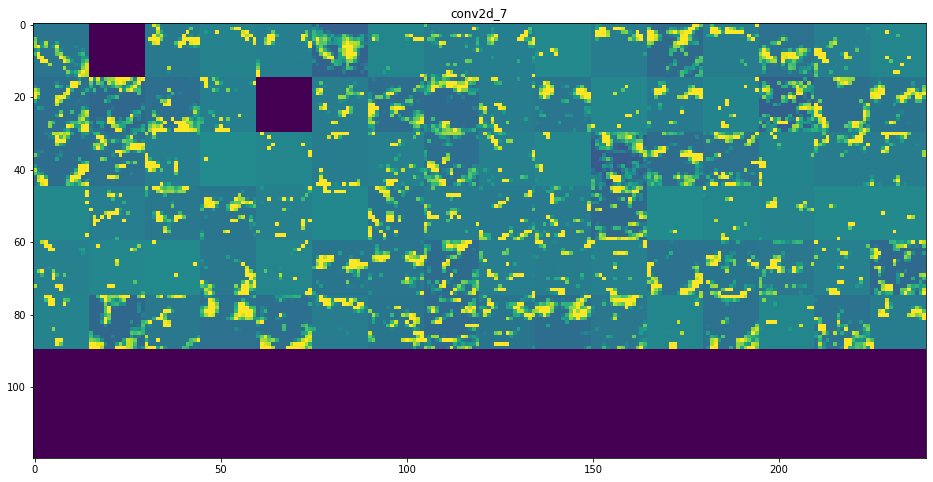

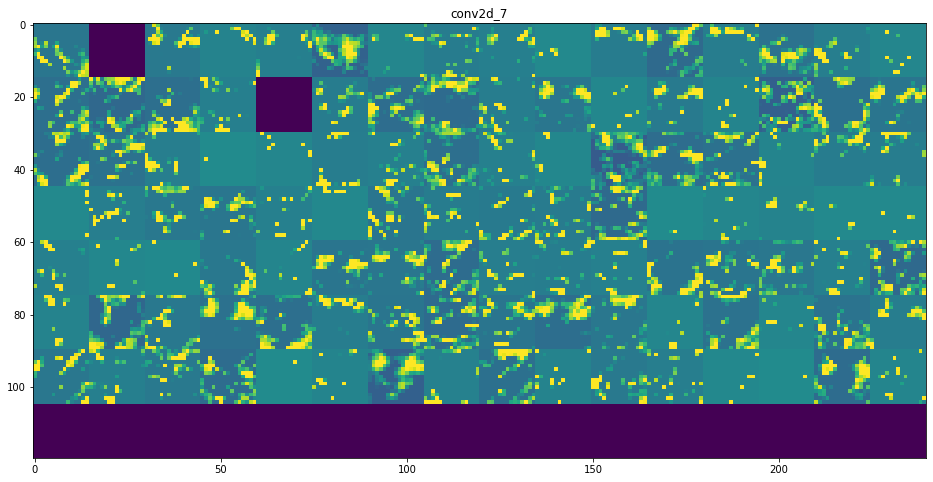

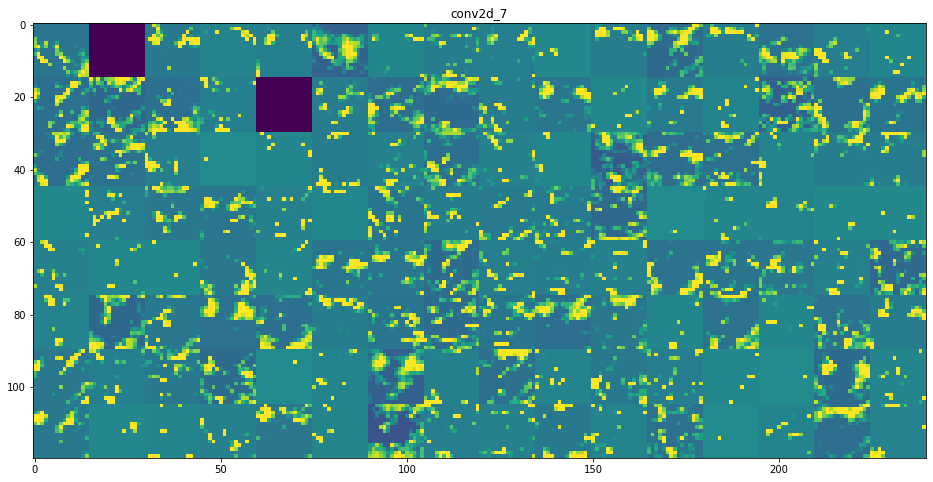

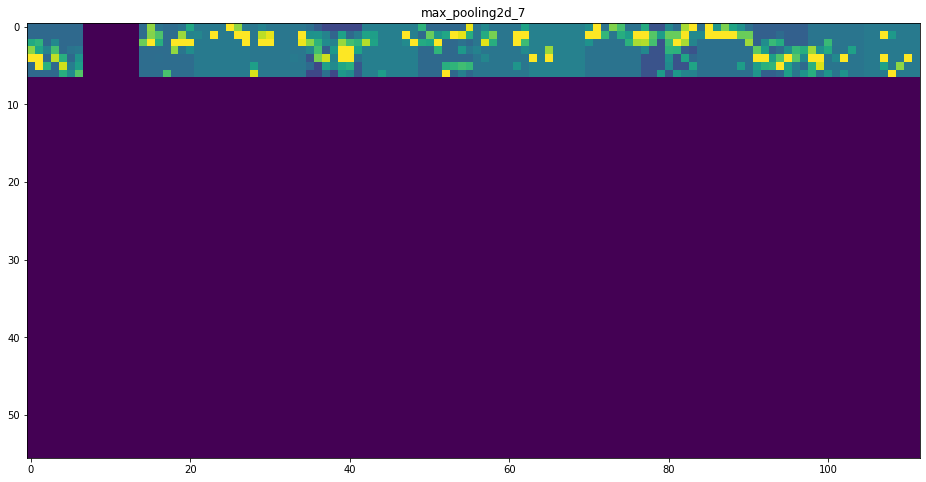

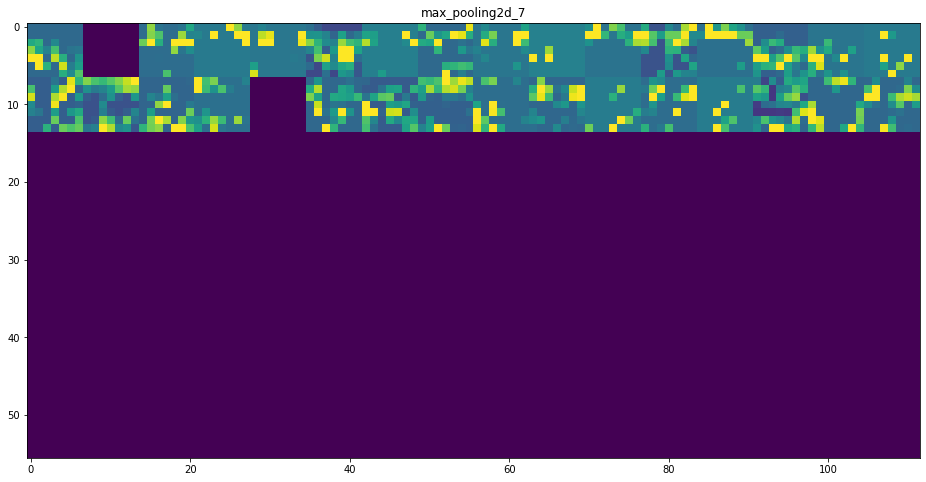

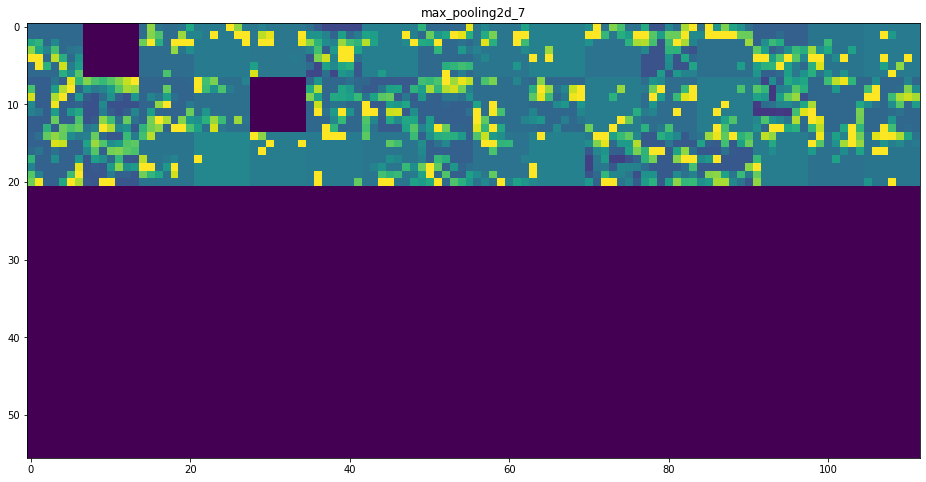

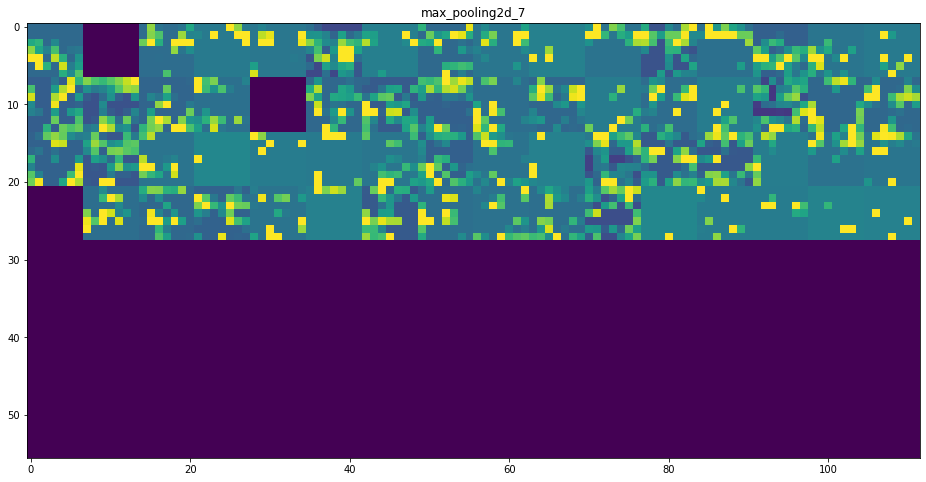

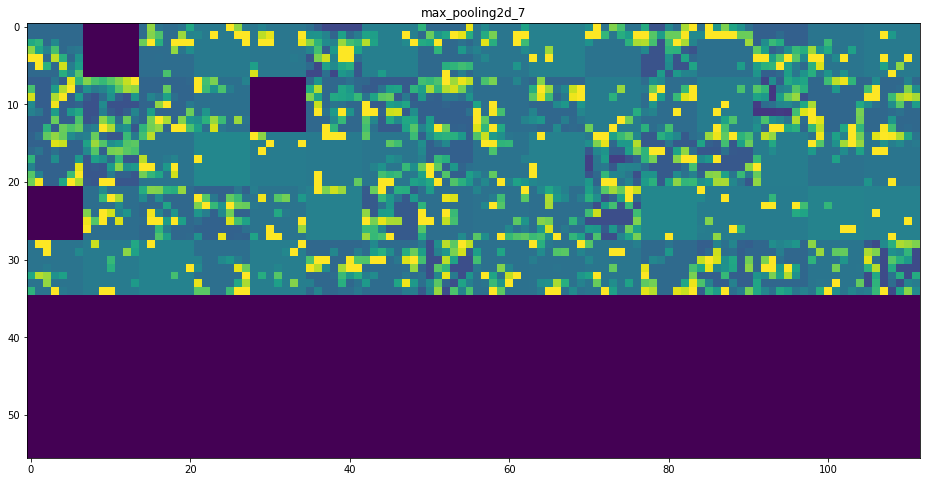

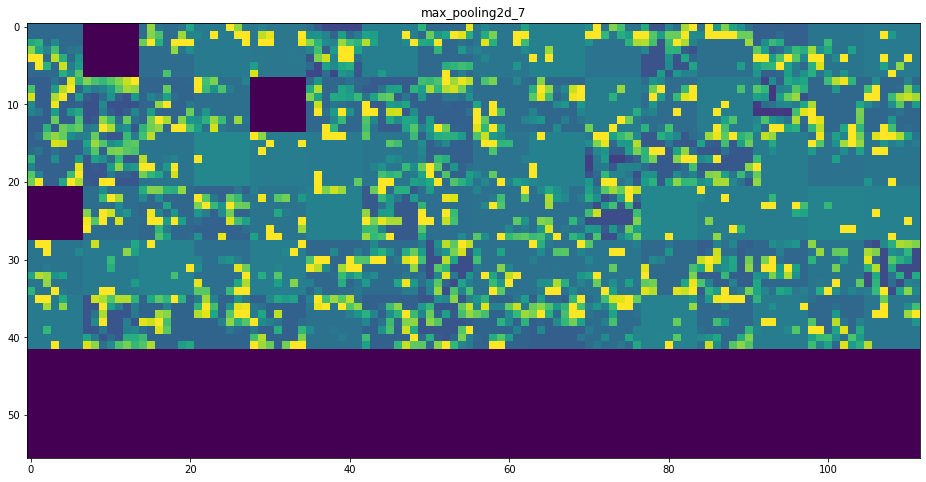

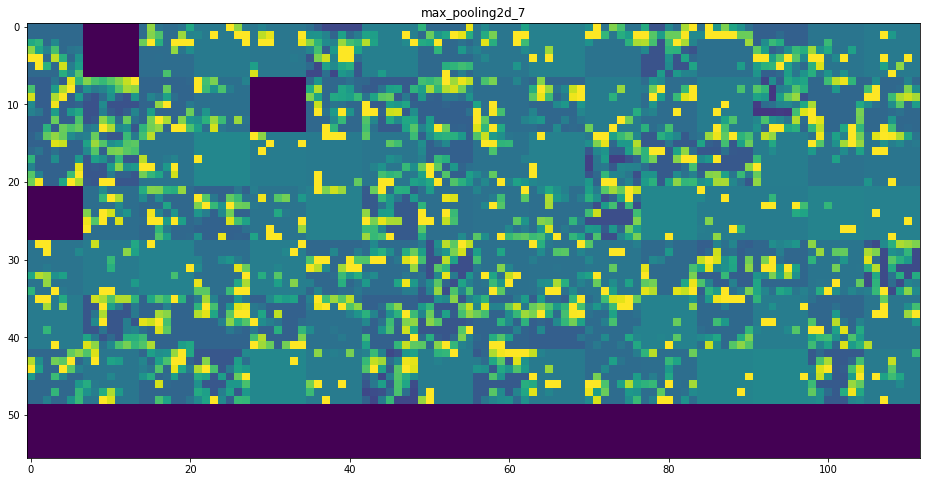

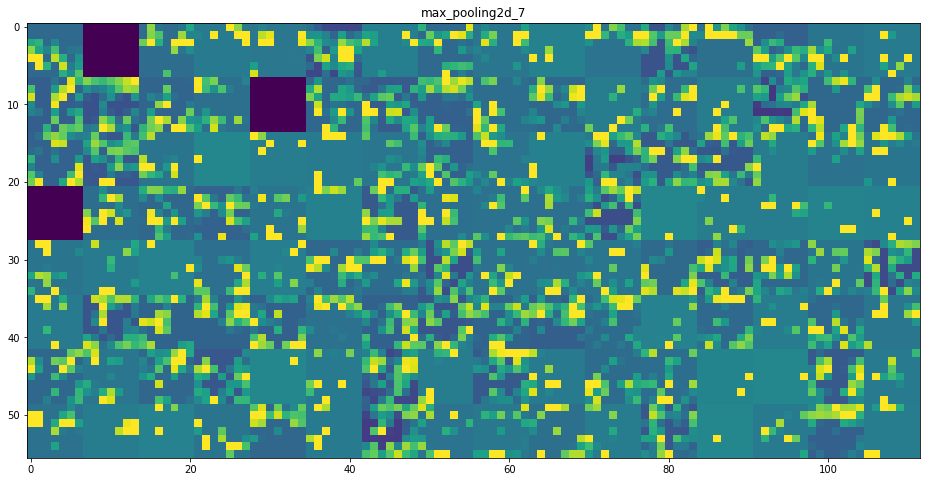

In [19]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size:(col + 1) * size, row * size: (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [8]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

@tf.function
def compute_gradients(input_data):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        output = model(input_data)
        layer_output_value = output[layer_name]
        loss_value = tf.reduce_mean(layer_output_value[:, :, :, filter_index])
    grads = tape.gradient(loss_value, input_data)
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    return loss_value, grads

input_img_data = tf.Variable(np.random.random((1, 150, 150, 3)) * 20 + 128, dtype=tf.float32)

step = 1.
for i in range(40):
    loss_value, grads_value = compute_gradients(input_img_data)
    input_img_data.assign_add(grads_value * step)



TypeError: in user code:

    File "/var/folders/2y/6zpyxsv91h5f6rkk2bhks16c0000gp/T/ipykernel_2273/1194488821.py", line 17, in compute_gradients  *
        layer_output_value = output[layer_name]

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'block3_conv1'
